[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1JbqQ8pWSN5AW0HE7elAlGvlNPfyyzdT1?usp=sharing)

# *Preparation*
---

In [ ]:
# Clone dataset
!git clone https://github.com/agrija9/Avalinguo-Audio-Set.git

Cloning into 'Avalinguo-Audio-Set'...
remote: Enumerating objects: 1482, done.
remote: Total 1482 (delta 0), reused 0 (delta 0), pack-reused 1482
Receiving objects: 100% (1482/1482), 283.21 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (1430/1430), done.


In [ ]:
# Import library
import os
import keras
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# *Variabel and Function Definition*
---

In [ ]:
# Definisi variabel
n_mfcc = 20
parent_dir = "Avalinguo-Audio-Set/audio files/"

In [ ]:
# Fungsi ekstraksi ciri
def feature_extraction(file_name):
    X , sample_rate = librosa.load(file_name)

    if X.ndim > 1:
        X = X[:,0]
    X = X.T
            
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_mfcc).T, axis=0)
    rmse = np.mean(librosa.feature.rms(y=X).T, axis=0)
    spectral_flux = np.mean(librosa.onset.onset_strength(y=X, sr=sample_rate).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)

    return mfccs, rmse, spectral_flux, zcr

In [ ]:
# Fungsi parsing file audio
def parse_audio_files(sub_dirs):
    number_of_features = 4 + n_mfcc
    dataset = np.empty((0,number_of_features))
    
    for sub_dir in sub_dirs:
        for file_name in os.scandir(os.path.join(parent_dir, sub_dir)):
            print("Actual File Name: ", file_name.path)
            try:
                mfccs, rmse, spectral_flux, zcr = feature_extraction(file_name.path)
            except Exception as e:
                print("[Error] there was an error in feature extraction. %s" % (e))
                continue
             
            extracted_features = np.hstack([mfccs, rmse, spectral_flux, zcr, sub_dir])
            dataset = np.vstack([dataset, extracted_features])
        print("Extracted features from %s, done" % (sub_dir))
        
    return np.array(dataset)

In [ ]:
# Fungsi parsing folder ke dataframe
def folder_to_dataframe(sub_dirs):
    folders = np.empty((0,2))
    for sub_dir in sub_dirs:
          for file_name in os.scandir(os.path.join(parent_dir, sub_dir)):
              folder_path = np.hstack([file_name.path, sub_dir])
              folders = np.vstack([folders, folder_path])
    
    return np.array(folders)

In [ ]:
# Fungsi menampilkan data
def display_data(file_name, clas):
    X , sample_rate = librosa.load(file_name)

    S = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128, fmax=8000)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_mfcc)

    fig, ax = plt.subplots(nrows=3, constrained_layout=True, figsize=[7,10])

    librosa.display.waveshow(X, sr=sample_rate, ax=ax[0])
    ax[0].set(title="Waveform")

    img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                                  x_axis="time", y_axis="mel", fmax=8000,
                                  ax=ax[1])
    fig.colorbar(img, ax=[ax[1]])
    ax[1].set(title="Mel spectrogram")

    img = librosa.display.specshow(mfccs, x_axis="time", ax=ax[2])
    fig.colorbar(img, ax=[ax[2]])
    ax[2].set(title="MFCC")

    display.display(display.Audio(np.transpose(X), rate=sample_rate))
    
    fig.suptitle(clas, fontsize=16)

In [ ]:
# Fungsi menampilkan plot
def show_graph(train, val, metric):
    plt.plot(train)
    plt.plot(val)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

# *Preprocessing*
---

In [ ]:
# Definisi path audio
audio_subdirectories = os.listdir(parent_dir)
audio_subdirectories.sort()
print("Audio Subdirs: ", audio_subdirectories)

Audio Subdirs:  ['001 - Low', '002 - Intermediate', '003 - High']


In [ ]:
# Parsing folder di dataset ke dataframe
folders = folder_to_dataframe(audio_subdirectories)

In [ ]:
# Membuat dataframe hasil parsing folder
columns = ["Path", "Class"]
df_folder = pd.DataFrame(folders, columns=columns)
df_folder.head()

,Path,Class
0,Avalinguo-Audio-Set/audio files/001 - Low/Aval...,001 - Low
1,Avalinguo-Audio-Set/audio files/001 - Low/Inte...,001 - Low
2,Avalinguo-Audio-Set/audio files/001 - Low/Aval...,001 - Low
3,Avalinguo-Audio-Set/audio files/001 - Low/Inte...,001 - Low
4,Avalinguo-Audio-Set/audio files/001 - Low/Aval...,001 - Low


In [ ]:
# Informasi dataframe
df_folder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    1424 non-null   object
 1   Class   1424 non-null   object
dtypes: object(2)
memory usage: 22.4+ KB


In [ ]:
# Mengubah nilai label
df_folder["Class"] = df_folder["Class"].replace(["001 - Low", "002 - Intermediate", "003 - High"], ["Low", "Intermediate", "High"])

<Axes: >

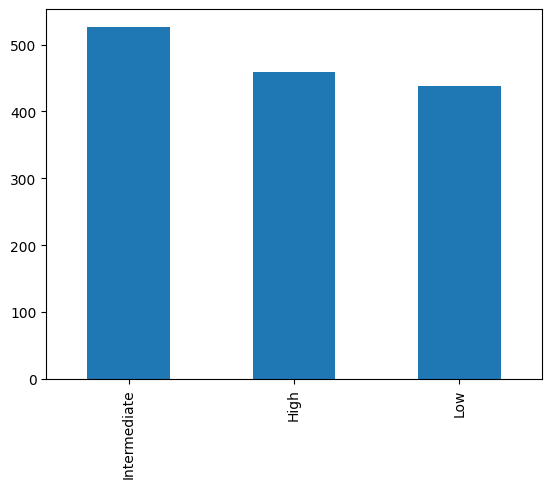

In [ ]:
# Visualisasi kolom "Class"
df_folder["Class"].value_counts().plot.bar()

In [ ]:
# Grouping dataset
df_group = df_folder.groupby("Class")
df_group.first()

,Path
Class,
High,Avalinguo-Audio-Set/audio files/003 - High/Won...
Intermediate,Avalinguo-Audio-Set/audio files/002 - Intermed...
Low,Avalinguo-Audio-Set/audio files/001 - Low/Aval...


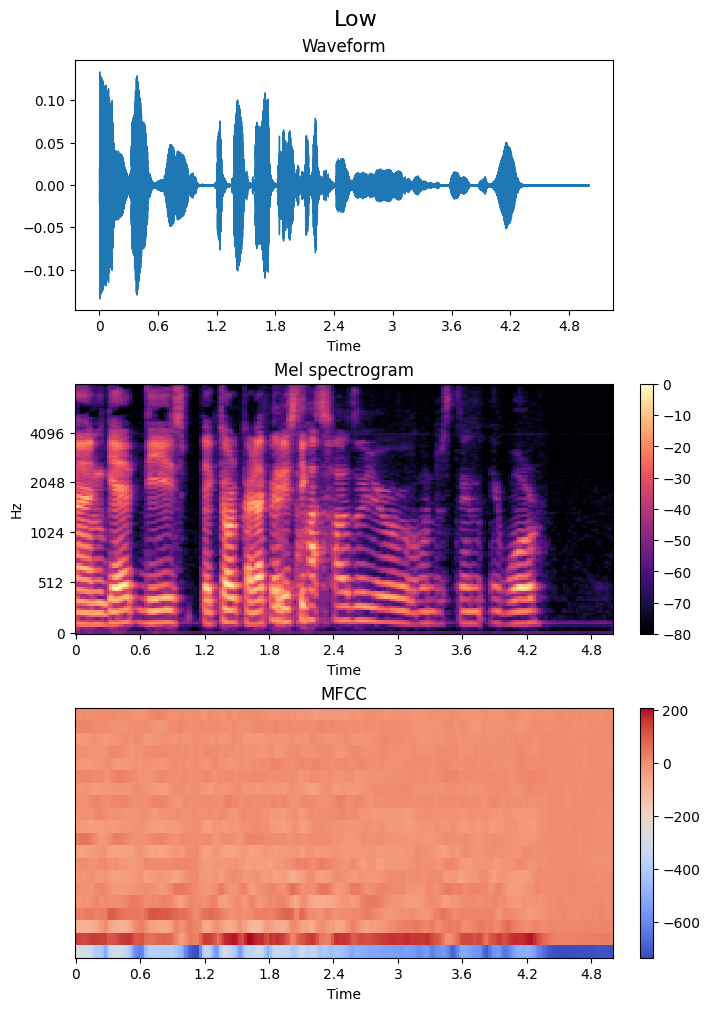

In [ ]:
# Menampilkan salah satu data di class "Low"
df_low = df_group.get_group("Low").sample()
display_data(df_low.iloc[0]["Path"],df_low.iloc[0]["Class"])

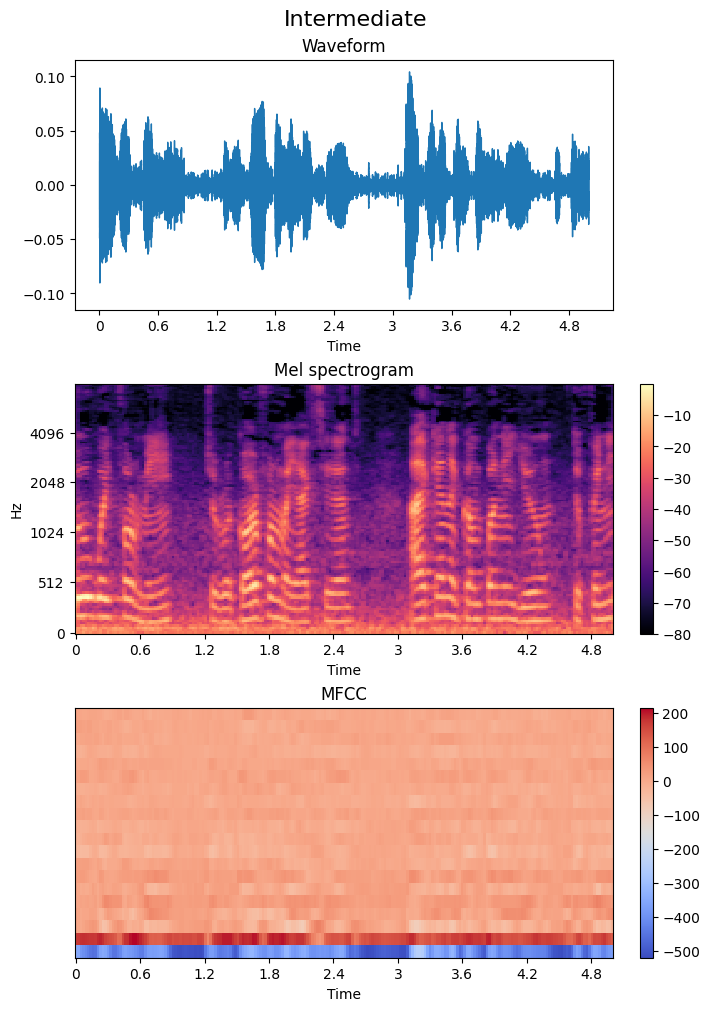

In [ ]:
# Menampilkan salah satu data di class "Intermediate"
df_intermediate = df_group.get_group("Intermediate").sample()
display_data(df_intermediate.iloc[0]["Path"],df_intermediate.iloc[0]["Class"])

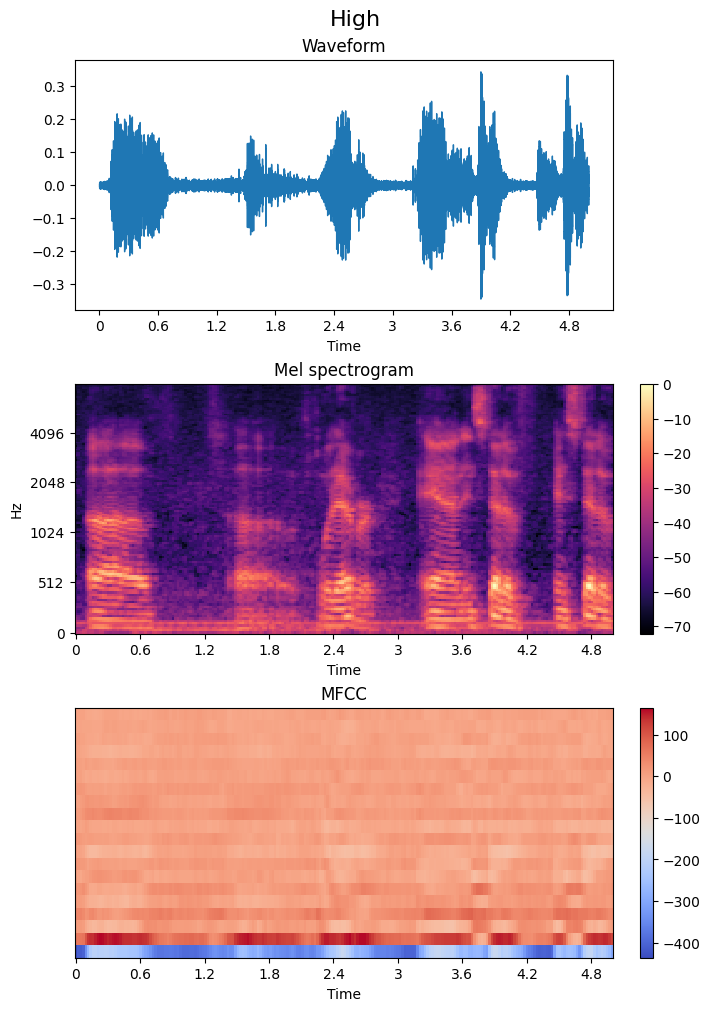

In [ ]:
# Menampilkan salah satu data di class "High"
df_high = df_group.get_group("High").sample()
display_data(df_high.iloc[0]["Path"],df_high.iloc[0]["Class"])

In [ ]:
# Parsing audio dalam folder
dataset = parse_audio_files(audio_subdirectories)

Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Victor and Abraham segment 99
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Interview with a Filippines Woman segment 9 - W
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Dana and Konay segment 72 - D
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Interview with a Filippines Woman segment 53 - W
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Victor and Abraham segment 73
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Victor and Abraham segment 58
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Dana and Konay segment 40 - D
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Victor and Abraham segment 27
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Dana and Konay segment 97 - D
Actual File Name:  Avalinguo-Audio-Set/audio files/001 - Low

In [ ]:
# Mengubah dataset hasil parsing audio ke dataframe dan menampilkan
df = pd.DataFrame(dataset)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-511.79672,104.35278,-18.64975,11.800529,-7.850605,-2.5272007,-7.165496,-5.04887,-18.967136,2.7184277,...,3.4794128,-2.949172,-4.204322,-9.463586,-3.0675704,-3.3209581,0.012758927,1.6552765,0.12145543981481481,001 - Low
1,-492.04465,81.15994,12.600917,19.893204,-14.314812,3.342746,-6.5459538,3.1919596,-8.578612,0.97596663,...,-5.9032526,2.5854063,-3.3418124,3.695677,1.0626414,5.945334,0.005579195,1.3025011,0.054149486400462965,001 - Low
2,-384.09897,76.623695,12.346456,44.026657,26.354967,11.47373,5.277666,10.38553,-6.401124,4.310745,...,1.9325805,0.8766929,-7.764441,5.8774557,-7.1407447,3.465004,0.015873296,1.5434061,0.09928837528935185,001 - Low
3,-478.79254,88.29062,2.1003573,13.695588,-14.998259,-1.907309,-10.693153,0.39430407,-15.071053,4.864185,...,-6.794634,4.0656734,-1.9220072,1.8322678,0.45327872,8.594068,0.006357033,1.4967378,0.07291666666666667,001 - Low
4,-601.01215,89.205414,-12.460351,20.99302,-0.6846607,3.542392,-4.3298907,-1.3801631,-7.62434,-4.784789,...,-1.5517898,-5.200928,-2.0126717,-6.716348,-2.923702,-3.787952,0.0033596957,1.4580133,0.12482593677662036,001 - Low


In [ ]:
# Informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1424 non-null   object
 1   1       1424 non-null   object
 2   2       1424 non-null   object
 3   3       1424 non-null   object
 4   4       1424 non-null   object
 5   5       1424 non-null   object
 6   6       1424 non-null   object
 7   7       1424 non-null   object
 8   8       1424 non-null   object
 9   9       1424 non-null   object
 10  10      1424 non-null   object
 11  11      1424 non-null   object
 12  12      1424 non-null   object
 13  13      1424 non-null   object
 14  14      1424 non-null   object
 15  15      1424 non-null   object
 16  16      1424 non-null   object
 17  17      1424 non-null   object
 18  18      1424 non-null   object
 19  19      1424 non-null   object
 20  20      1424 non-null   object
 21  21      1424 non-null   object
 22  22      1424 non-null   

In [ ]:
# Mengubah tipe data menjadi float
columns = {0:"float",1:"float",2:"float",3:"float",4:"float",5:"float",6:"float",7:"float",8:"float",9:"float",10:"float",11:"float",12:"float",13:"float",14:"float",15:"float",16:"float",17:"float",18:"float",19:"float",20:"float",21:"float",22:"float"}
df = df.astype(columns)

In [ ]:
# Mencari nilai unik kolom 23 / label / kelas
df[23].value_counts()

002 - Intermediate    527
003 - High            459
001 - Low             438
Name: 23, dtype: int64

In [ ]:
# Mengubah nilai label
df[23] = df[23].replace(["001 - Low", "002 - Intermediate", "003 - High"], [0, 1, 2])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-511.79672,104.352780,-18.649750,11.800529,-7.850605,-2.527201,-7.165496,-5.048870,-18.967136,2.718428,...,3.479413,-2.949172,-4.204322,-9.463586,-3.067570,-3.320958,0.012759,1.655277,0.121455,0
1,-492.04465,81.159940,12.600917,19.893204,-14.314812,3.342746,-6.545954,3.191960,-8.578612,0.975967,...,-5.903253,2.585406,-3.341812,3.695677,1.062641,5.945334,0.005579,1.302501,0.054149,0
2,-384.09897,76.623695,12.346456,44.026657,26.354967,11.473730,5.277666,10.385530,-6.401124,4.310745,...,1.932581,0.876693,-7.764441,5.877456,-7.140745,3.465004,0.015873,1.543406,0.099288,0
3,-478.79254,88.290620,2.100357,13.695588,-14.998259,-1.907309,-10.693153,0.394304,-15.071053,4.864185,...,-6.794634,4.065673,-1.922007,1.832268,0.453279,8.594068,0.006357,1.496738,0.072917,0
4,-601.01215,89.205414,-12.460351,20.993020,-0.684661,3.542392,-4.329891,-1.380163,-7.624340,-4.784789,...,-1.551790,-5.200928,-2.012672,-6.716348,-2.923702,-3.787952,0.003360,1.458013,0.124826,0


In [ ]:
# One hot encoding
df_category = pd.get_dummies(df[23])

In [ ]:
# Menampilkan
df_category.tail()

,0,1,2
1419,0,0,1
1420,0,0,1
1421,0,0,1
1422,0,0,1
1423,0,0,1


In [ ]:
# Menggabungkan dataset
new_df = pd.concat([df, df_category], axis=1)
new_df = new_df.drop(columns=23)
new_df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,0,1,2
0,-511.79672,104.352780,-18.649750,11.800529,-7.850605,-2.527201,-7.165496,-5.048870,-18.967136,2.718428,...,-4.204322,-9.463586,-3.067570,-3.320958,0.012759,1.655277,0.121455,1,0,0
1,-492.04465,81.159940,12.600917,19.893204,-14.314812,3.342746,-6.545954,3.191960,-8.578612,0.975967,...,-3.341812,3.695677,1.062641,5.945334,0.005579,1.302501,0.054149,1,0,0
2,-384.09897,76.623695,12.346456,44.026657,26.354967,11.473730,5.277666,10.385530,-6.401124,4.310745,...,-7.764441,5.877456,-7.140745,3.465004,0.015873,1.543406,0.099288,1,0,0
3,-478.79254,88.290620,2.100357,13.695588,-14.998259,-1.907309,-10.693153,0.394304,-15.071053,4.864185,...,-1.922007,1.832268,0.453279,8.594068,0.006357,1.496738,0.072917,1,0,0
4,-601.01215,89.205414,-12.460351,20.993020,-0.684661,3.542392,-4.329891,-1.380163,-7.624340,-4.784789,...,-2.012672,-6.716348,-2.923702,-3.787952,0.003360,1.458013,0.124826,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,-478.44770,162.112050,-26.773241,-0.353233,16.681177,-16.067345,-1.692882,-3.317611,-14.368171,3.761534,...,-8.475529,-5.355106,-4.518387,-9.487754,0.013888,1.645406,0.056403,0,0,1
1420,-269.60443,83.542660,-1.810608,54.100370,7.166884,22.110226,-9.676256,-0.685217,-15.254975,10.214760,...,-8.433704,-2.875225,-2.850660,-4.281110,0.034245,1.491136,0.128583,0,0,1
1421,-288.86210,103.255226,-0.596324,48.992046,3.862799,18.932188,-11.978194,2.049146,-21.957117,10.144612,...,-7.781985,-2.710170,-5.507230,-0.263818,0.030637,1.542892,0.099795,0,0,1
1422,-526.94900,148.283460,-19.287040,9.087389,13.873146,-18.767693,2.567736,-0.225501,-14.763179,1.445003,...,-5.801862,-3.283025,-5.633538,-9.536732,0.009328,1.594985,0.066696,0,0,1


In [ ]:
# Mengubah ke numpy
dataset = new_df.values
dataset

array([[-511.79672  ,  104.35278  ,  -18.64975  , ...,    1.       ,
           0.       ,    0.       ],
       [-492.04465  ,   81.15994  ,   12.600917 , ...,    1.       ,
           0.       ,    0.       ],
       [-384.09897  ,   76.623695 ,   12.346456 , ...,    1.       ,
           0.       ,    0.       ],
       ...,
       [-288.8621   ,  103.255226 ,   -0.5963235, ...,    0.       ,
           0.       ,    1.       ],
       [-526.949    ,  148.28346  ,  -19.28704  , ...,    0.       ,
           0.       ,    1.       ],
       [-294.25345  ,  107.006355 ,   -5.1529446, ...,    0.       ,
           0.       ,    1.       ]])

In [ ]:
# Mendefinisi variabel X
X = dataset[:,0:23]
X

array([[-5.11796720e+02,  1.04352780e+02, -1.86497500e+01, ...,
         1.27589270e-02,  1.65527650e+00,  1.21455440e-01],
       [-4.92044650e+02,  8.11599400e+01,  1.26009170e+01, ...,
         5.57919500e-03,  1.30250110e+00,  5.41494864e-02],
       [-3.84098970e+02,  7.66236950e+01,  1.23464560e+01, ...,
         1.58732960e-02,  1.54340610e+00,  9.92883753e-02],
       ...,
       [-2.88862100e+02,  1.03255226e+02, -5.96323500e-01, ...,
         3.06366050e-02,  1.54289220e+00,  9.97947410e-02],
       [-5.26949000e+02,  1.48283460e+02, -1.92870400e+01, ...,
         9.32798900e-03,  1.59498490e+00,  6.66956019e-02],
       [-2.94253450e+02,  1.07006355e+02, -5.15294460e+00, ...,
         2.24648790e-02,  1.26662360e+00,  8.89892578e-02]])

In [ ]:
# Mendefinisi variabel Y
y = dataset[:,23:26]
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=230)

In [ ]:
# Scalling
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

In [ ]:
# Expand dimensi X
X_train_scal_ex = np.expand_dims(X_train_scal, axis=1)
X_test_scal_ex = np.expand_dims(X_test_scal, axis=1)

In [ ]:
# Menampilkan ukuran dataset
print("X_train shape:", X_train_scal_ex.shape)
print("X_test shape:", X_test_scal_ex.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (996, 1, 23)
X_test shape: (428, 1, 23)
y_train shape: (996, 3)
y_test shape: (428, 3)


# *Build Model RNN LSTM*
---

In [ ]:
# Build Model RNN Neural Network LSTM
print("Build LSTM RNN model ...")
model = keras.models.Sequential()
model.add(keras.layers.LSTM(256, activation="relu", return_sequences=True, input_shape=X_train_scal_ex.shape[1:]))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128, activation="relu", return_sequences=True))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(64, activation="relu", return_sequences=False))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(3, activation="softmax"))
          
print("Compiling ...")
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

print(model.summary())

Build LSTM RNN model ...
Compiling ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            286720    
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)   

# *Training*
---

In [ ]:
# Training model
print("Training ...")
history = model.fit(X_train_scal_ex, y_train, batch_size=64, validation_split = 0.1, epochs=130, shuffle=True)

Training ...
Epoch 1/130
14/14 [==============================] - 4s 58ms/step - loss: 1.0982 - accuracy: 0.3460 - val_loss: 1.0974 - val_accuracy: 0.3700
Epoch 2/130
14/14 [==============================] - 0s 17ms/step - loss: 1.0972 - accuracy: 0.3583 - val_loss: 1.0962 - val_accuracy: 0.3700
Epoch 3/130
14/14 [==============================] - 0s 17ms/step - loss: 1.0955 - accuracy: 0.3583 - val_loss: 1.0941 - val_accuracy: 0.3700
Epoch 4/130
14/14 [==============================] - 0s 17ms/step - loss: 1.0930 - accuracy: 0.3583 - val_loss: 1.0901 - val_accuracy: 0.3700
Epoch 5/130
14/14 [==============================] - 0s 18ms/step - loss: 1.0864 - accuracy: 0.3683 - val_loss: 1.0810 - val_accuracy: 0.3700
Epoch 6/130
14/14 [==============================] - 0s 17ms/step - loss: 1.0722 - accuracy: 0.4196 - val_loss: 1.0598 - val_accuracy: 0.5400
Epoch 7/130
14/14 [==============================] - 0s 18ms/step - loss: 1.0357 - accuracy: 0.5156 - val_loss: 1.0091 - val_accuracy: 

# *Validation*
---

In [ ]:
# Validasi
print("Validating ...")
score, accuracy = model.evaluate(X_test_scal_ex, y_test, batch_size=32, verbose=1)
print("Loss:  ", score)
print("Accuracy:  ", accuracy)

Validating ...
14/14 [==============================] - 0s 16ms/step - loss: 0.4077 - accuracy: 0.9252
Loss:   0.40771540999412537
Accuracy:   0.9252336621284485


# *Prediction*
----

In [ ]:
# Cek salah satu nilai prediksi
print(y_test[:1])
print(X_test[:1])

[[0. 1. 0.]]
[[-2.64943080e+02  1.30478040e+02 -2.27670760e+01  2.90637930e+01
   1.48015090e+01 -4.60973800e+00  3.79529300e+00  1.15272150e+00
  -6.62536700e+00  2.77616900e+00 -5.80081370e+00  3.12757250e+00
  -5.09741300e-01 -1.82792630e-01  7.79571100e-01  6.42216160e+00
  -6.73386430e+00  5.89802930e+00 -1.27484670e+00  4.93299150e+00
   4.89503220e-02  1.18255660e+00  6.10916703e-02]]


In [ ]:
# Melakukan prediksi
pred = model.predict(X_test_scal_ex[:1])
pred

1/1 [==============================] - 0s 422ms/step


array([[2.9705063e-10, 1.0000000e+00, 1.1858542e-08]], dtype=float32)

In [ ]:
# Hasil prediksi
classes = np.argmax(pred, axis = 1)
print(classes)

[1]


In [ ]:
# Prediksi dataset testing
y_predict = model.predict(X_test_scal_ex)

14/14 [==============================] - 0s 6ms/step


In [ ]:
# Mendapatkan hasil prediksi
y_test_arg = np.argmax(y_test, axis=1)
y_predict = np.argmax(y_predict, axis = 1)

# *Evaluation*
---

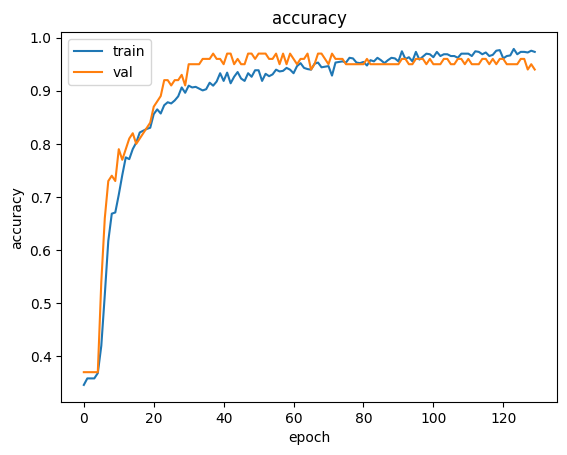

In [ ]:
# Menampilkan plot akurasi
show_graph(history.history["accuracy"], history.history["val_accuracy"], "accuracy")

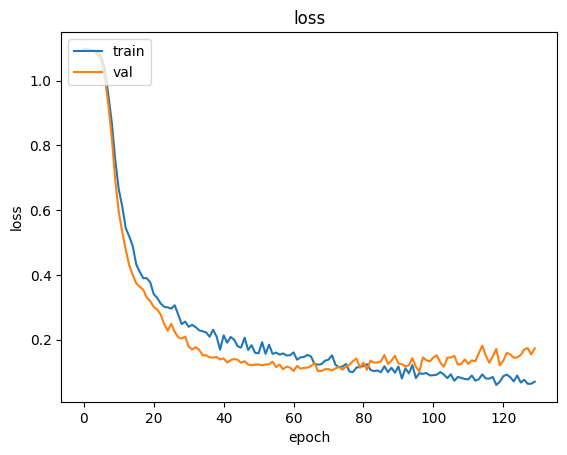

In [ ]:
# Menampilkan plot loss
show_graph(history.history["loss"], history.history["val_loss"], "loss")

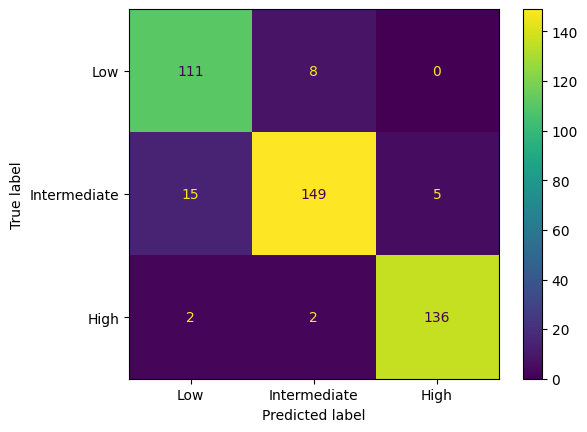

In [ ]:
# Menampilkan confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_arg, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Low", "Intermediate", "High"])
cm_display.plot()
plt.show()

# *Saving Models*
---

In [ ]:
# Save model
model.save("fluency_model_calibration.h5")